<a href="https://colab.research.google.com/github/VladKarad/AI_education/blob/main/ChatBot_Text%20processing_Model_Sequence_to_Sequence_HW_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Добро пожаловать на задание уровня Pro.
Необходимо написать чат-бота, испльзуя модель seq2seq.

Ссылка на базу https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt

База содержит примеры пар: вопрос-ответ. По аналогии с моделью преводчика (англ - рус), создайте чат-бота (вопрос - ответ)

In [ ]:
# Подключим модуль для загрузки файлов в colab
from google.colab import files

# Подключим модуль numpy для работы с массивами
import numpy as np

# Подгрузим модели кераса
from tensorflow.keras.models import Model, load_model

# Подключим нужные слои
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# Поключим оптимайзеры
from tensorflow.keras.optimizers import RMSprop, Adadelta

# Подключим метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Подключим модуль для one hot кодировки
from tensorflow.keras import utils

# Подключим визуализацию графа модели
from tensorflow.keras.utils import plot_model

# Подключим модуль для работы с yaml - файлами
import yaml

In [ ]:
# Загрузим обучающие тексты
!wget  https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt

--2022-01-11 09:17:06--  https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 748135 (731K) [text/plain]
Saving to: ‘9kdialogs.txt’

9kdialogs.txt       100%[===================>] 730.60K  --.-KB/s    in 0.007s  

2022-01-11 09:17:07 (105 MB/s) - ‘9kdialogs.txt’ saved [748135/748135]



In [ ]:
conversations = [] 
with open("/content/9kdialogs.txt", 'r', encoding='utf-8') as f: # Открываем файл словаря в режиме чтения
    lines = f.read().replace("\n\n","").split('- -')                  # Читаем весь файл, режем на строки

# Цикл по строкам
for i,line in enumerate(lines):
    #if i>50000:                                         # Нам нужно только 50000 первых строк
    #  break                                             # Заканчиваем цикл
    try:
        input_text, target_text,_ = line.split("\n")    # Берем очередную строку, режем по символу табуляции
        conversations.append([input_text, target_text]) # Заполняем список пар фраз
    except:
        continue                                        # если не получается - идем за следущей строкой

In [ ]:
len(conversations)

828

In [ ]:
def my_replacer(s): # Принимаем на вход строку или список

    '''
    Функция удаления пробелов из строк или списков, в зависимости от того, что подано на вход
  
    Args:
        s - Строка или список
    Returns:
  
        Список строк если получили список
        Строку, если получили строку
        
    '''


    if isinstance(s,str): # Если получили строку

        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

    if isinstance(s,list): # Если получили список
        ou=[]              # Заготовим пустой список

        for l in s:        # Цикл по строкам из списка
            ou.append(l.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')) # Убираем перед знаками препинания пробел и возвращаем

        # Вернем список строк
        return ou    

In [ ]:
# Собираем вопросы и ответы в списки

questions = [] # Переменная для списка входных фраз
answers = []   # Переменная для списка ответных фраз

# Цикл по всем парам фраз 
for con in conversations:                 
  if len(con) > 1 :                       # Если ответная фраза содержит более одно двух предложений
    questions.append(my_replacer(con[0])) # То первую в списке фразу отправляем в список входных фраз
    replies = my_replacer(con[1:])        # А ответную составляем из последующих строк
    ans = ' '.join(replies)               # Здесь соберем ответ
    answers.append(ans)                   # Добавим в список ответов
  else:
    continue                              # Иначе идем на новой парой фраз

# Добавим в каждую ответную фразу теги  <START> и <END>
answers = ['<START> ' + s + ' <END>' for s in answers]

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[111])) # Пример входной фразы
print('Ответ : {}'.format(answers[111]))    # Пример ответной фразы

Вопрос :  Ваша машина?
Ответ : <START> - Моя... <END>


In [ ]:
# Создадим токенайзер 
tokenizer = Tokenizer(filters='"#$%&()*+-/;<=>@[\\]^_`{|}~\t\n',split=' ')  

# Загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions + answers)         

# Список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())    

# Размер словаря
vocabularySize = len(vocabularyItems)+1        

# Выведем фрагмент и размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))       
print( 'Размер словаря : {}'.format(vocabularySize))             

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('ты', 5), ('а', 6), ('в', 7), ('это', 8), ('я', 9), ('вы', 10), ('что?', 11), ('да.', 12), ('где', 13), ('у', 14), ('и', 15), ('нет.', 16), ('на', 17), ('как', 18), ('кто', 19), ('с', 20), ('за', 21), ('же', 22), ('тебе', 23), ('он', 24), ('то', 25), ('нет,', 26), ('мне', 27), ('это?', 28), ('вас', 29), ('да,', 30), ('сколько', 31), ('вам', 32), ('еще', 33), ('кого?', 34), ('есть', 35), ('чего', 36), ('ну', 37), ('его', 38), ('только', 39), ('как?', 40), ('из', 41), ('меня', 42), ('она', 43), ('да', 44), ('здесь', 45), ('так', 46), ('тебя', 47), ('все', 48), ('мы', 49), ('ну,', 50)]
Размер словаря : 2357


In [ ]:
# Разбиваем текст входных фраз на последовательности индексов
tokenizedQuestions = tokenizer.texts_to_sequences(questions)

# Уточняем длину самой длинной фразы
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])

# Делаем последовательности одной длины, заполняя нулями более короткие фразы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
encoderForInput = np.array(paddedQuestions)        

# Выведем на экран
print('Пример входной фразы                         : {}'.format(questions[100]))         
print('Пример кодированной входной фразу            : {}'.format(encoderForInput[100]))  
print('Размеры закодированного массива входных фраз : {}'.format(encoderForInput.shape))  
print('Установленная длина входных фраз             : {}'.format(maxLenQuestions))        

Пример входной фразы                         :  Кто-то здесь есть.
Пример кодированной входной фразу            : [ 19  25  45 140   0   0   0   0   0   0   0]
Размеры закодированного массива входных фраз : (828, 11)
Установленная длина входных фраз             : 11


In [ ]:
# Разбиваем текст ответных фраз на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

# Уточняем длину самого длинного ответа
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины, заполняя нулями более ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть, переводим в numpy массив
decoderForInput = np.array(paddedAnswers)               

# Выведем на экран
print('Пример оригинального ответа на вход: {}'.format(answers[100]))                         
print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:30]))           
print('Размеры кодированного массива ответов на вход : {}'.format(decoderForInput.shape))     
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers))                       

Пример оригинального ответа на вход: <START> - Это сквозняк, мы просто не прикрыли дверь. <END>
Пример кодированного ответа на вход : [   1    8 1469   49  113    4 1470  444    2    0    0    0    0    0
    0    0    0]
Размеры кодированного массива ответов на вход : (828, 17)
Установленная длина ответов на вход : 17


In [ ]:
# Разбиваем текст ответов на последовательности индексов
tokenizedAnswers = tokenizer.texts_to_sequences(answers) 

for i in range(len(tokenizedAnswers)) :                  # Для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]          # Избавляемся от тега <START>

# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post') 

# И сохраняем в виде массива numpy
decoderForOutput = np.array(paddedAnswers)                     

In [ ]:
# Выведем на экран

print('Пример кодированного ответа на вход : {}'.format(decoderForInput[100][:21]))   
print('Пример кодированного ответа на выход : {}'.format(decoderForOutput[100][:21]))
print('Размеры кодированного массива ответов на выход : {}'.format(decoderForOutput.shape))  
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers))                    

Пример кодированного ответа на вход : [   1    8 1469   49  113    4 1470  444    2    0    0    0    0    0
    0    0    0]
Пример кодированного ответа на выход : [   8 1469   49  113    4 1470  444    2    0    0    0    0    0    0
    0    0    0]
Размеры кодированного массива ответов на выход : (828, 17)
Установленная длина вопросов на выход : 17


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    471400      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    471400      ['input_2[0][0]']                
                                                                                              

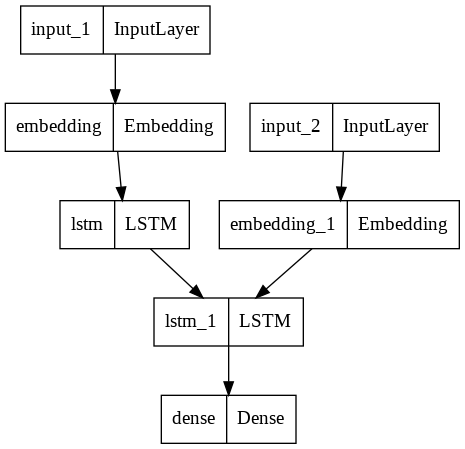

In [ ]:
# Создадим энкодер 

encoderInputs = Input(shape=(None , ))                                               # Добавим входной слой
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs)    # Добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)   # Добавим LSTM
encoderStates = [state_h, state_c]                                                   # Соберем выходы lstm  в список    

# Создадим декодер 

decoderInputs = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs)    # Добавим эмбеддинг
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates) # Прогоним выход embedding через LSTM
decoderDense = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output = decoderDense (decoderOutputs)                                               # Прогоним  выход LSTM через DENSE

model = Model([encoderInputs, decoderInputs], output)                                # Собираем модель
model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')           # Компилиуем модель
print(model.summary())                                                               # Выведем на экран информацию о построенной модели нейросети


# Построим график для визуализации слоев и связей между ними
plot_model(model)

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=128, epochs=100) 

Epoch 1/100
7/7 [==============================] - 13s 35ms/step - loss: 2.1828
Epoch 2/100
7/7 [==============================] - 0s 36ms/step - loss: 1.5696
Epoch 3/100
7/7 [==============================] - 0s 38ms/step - loss: 1.4671
Epoch 4/100
7/7 [==============================] - 0s 36ms/step - loss: 1.4242
Epoch 5/100
7/7 [==============================] - 0s 35ms/step - loss: 1.3963
Epoch 6/100
7/7 [==============================] - 0s 36ms/step - loss: 1.3654
Epoch 7/100
7/7 [==============================] - 0s 35ms/step - loss: 1.3372
Epoch 8/100
7/7 [==============================] - 0s 35ms/step - loss: 1.3090
Epoch 9/100
7/7 [==============================] - 0s 36ms/step - loss: 1.2847
Epoch 10/100
7/7 [==============================] - 0s 37ms/step - loss: 1.2595
Epoch 11/100
7/7 [==============================] - 0s 37ms/step - loss: 1.2378
Epoch 12/100
7/7 [==============================] - 0s 36ms/step - loss: 1.2171
Epoch 13/100
7/7 [==============================

In [ ]:
# Создаем рабочие модели для перевода

def makeInferenceModels():

  '''
  Функция для создания единой полноценной модели из энкодера и декодера
  Собираем по отдельности энкодер и декодер для использования метода .predict() для каждого из них в конце работы для проверки результатов

  Args:
    None
    
  Returns:
    Вовзращает рабочие модели энкодера и декодера для дальнейшей работы нейросети
  '''

  # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  # Создадим модель декодера
  decoderStateInput_h = Input(shape=(200 ,)) # Добавим входной слой для state_h
  decoderStateInput_c = Input(shape=(200 ,)) # Добавим входной слой для state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # Соберем оба inputs вместе и запишем в decoderStatesInputs

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs) # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderStates = [state_h, state_c]            # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # И ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  # Вернем рабочие модели энкодера и декодера  
  return encoderModel , decoderModel

In [ ]:
def strToTokens(sentence: str):     # Функция принимает входную фразу

  '''
  Функция для очистки фразы и преобразования в индексы по словарю в токенайзере

  Args:
    sentence - фраза, формата str

  Returns:
    None, если незнакомые символы фразы
    Входная фраза в виде последовательности символов, если смогли определить индексы
  '''
  
  tmp_sent = my_replacer(sentence)                                              # Почистим фразу
  words = tmp_sent.lower().split()                                              # Приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list()                                                           # Здесь будет последовательность токенов/индексов

  # Для каждого слова в предложении
  for word in words:
    try:
        tokensList.append(tokenizer.word_index[word])                           # Определяем токенайзером индекс и добавляем в список
    except:
        pass                                                                    # Слова нет - просто игнорируем его

  # Вернёт входную фразу в виде последовательности индексов
  if tokensList:
    return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

  return None                                                                   # Фраза из незнакомх слов - вернем None 

In [ ]:
# Запускаем функцию для построения модели кодера и декодера

encModel , decModel = makeInferenceModels() 

In [ ]:
# Цикл по количеству входных фраз - их 1
for _ in range(1): # задаем количество вопросов, и на каждой итерации в этом диапазоне:

  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  decodedTranslation0 = input('Задай вопрос - получишь ответ от бота: ')
  qua  = strToTokens(decodedTranslation0)

  if qua is None:                                      # В запросе сплошные незнакомые слова...
    print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
    continue                                           # Пойдем за следущей фразой

  statesValues = encModel.predict(qua)                 # Прогоним фразу через энкодер
  
  emptyTargetSeq = np.zeros((1, 1))                    # Создадим пустой массив
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # Положим в пустую последовательность начальное слово 'start' в виде индекса
  stopCondition = False                                # Зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = ''                              #Здесь будет собираться генерируемый ответ

  while not stopCondition:                             # пока не сработало стоп-условие

    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) # Получим индекс предсказанного слова.
    sampledWord = None                                 # Создаем переменную, в которую положим слово, преобразованное на естественный язык

    # Цикл по всем индексам токенайзера
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:              # Если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # Слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word                       # Выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # Срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1))       # Создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # Заносим туда индекс выбранного слова
    statesValues = [h, c]                   # И состояния, обновленные декодером 
                                            # И продолжаем цикл с обновленными параметрами
  
  print("И бот ответил: ", decodedTranslation) # Выводим ответ сгенерированный декодером

Задай вопрос - получишь ответ от бота: как
И бот ответил:   ну, вроде жопа . end
